# Geostrophy
## $$f v = \frac{\partial m}{\partial\tilde{x}} = \frac{\partial m(z)}{\partial x}(\tilde{b}) + \zeta\frac{\partial b(z)}{\partial x}(\tilde{b})$$
## $$f u = -\frac{\partial m}{\partial\tilde{y}} = - \Big(\frac{\partial m(z)}{\partial y}(\tilde{b}) + \zeta\frac{\partial b(z)}{\partial y}(\tilde{b})\Big)$$
where $m\ (= \Phi - \tilde{b}\zeta)$ is the Montgomery pressure and $\frac{\partial m}{\partial\tilde{b}} = -\zeta$. 

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:57649")
client

<Client: 'tcp://127.0.0.1:57649' processes=8 threads=40, memory=169.33 GB>

In [2]:
import numpy as np
import xarray as xr
# from dask.diagnostics import ProgressBar
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid as xgrid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 23
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ystart = -10
yend = 50

In [6]:
xchunk = 500

for memb in range(24,26):
    if memb == 24:
        dsocn = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % memb), 
                                grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                prefix = ['diag_ocnSnap','diag_ocnSurf'], delta_t = 2e2,
                                iters = range(790560,946080,2160)
                               ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk})

#         dsaml = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012/cheapaml/' % memb),
#                                 grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                 prefix = ['diag_cheapAML'], delta_t = 2e2
#                                ).isel(time=slice(None,3)).chunk({'XC':xchunk,'XG':xchunk})
    else:
        dsocn = xr.concat([dsocn,open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' 
                                                         % memb), 
                                                 grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                 prefix = ['diag_ocnSnap','diag_ocnSurf'], delta_t = 2e2,
                                                 iters = range(790560,946080,2160)
                                                ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk})
                          ], dim='nmemb')
dsocn

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, nmemb: 2)
Coordinates:
    dyC      (YG, XC) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
    maskS    (Z, YG, XC) bool True True True True ... False False False False
    dxG      (YG, XC) >f4 8993.141 8993.141 8993.141 ... 5493.54 5493.54 5493.54
    hFacS    (Z, YG, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    time     float64 1.581e+08
    drC      (Zp1) >f4 3.0467727 6.407276 6.909917 ... 250.18945 125.23146
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    rAw      (YC, XG) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    maskInS  (YG, XC) bool False False False False False ... True True True True
    dyG      (YC, XG) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
    iter     int64 790560
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    maskC    (Z, YC, XC) bool True Tru

{'standard_name': 'PHIHYD', 'long_name': 'Hydrostatic Pressure Pot.(p/rho) Anomaly', 'units': 'm^2/s^2'} {'standard_name': 'ETAN', 'long_name': 'Surface Height Anomaly', 'units': 'm'}


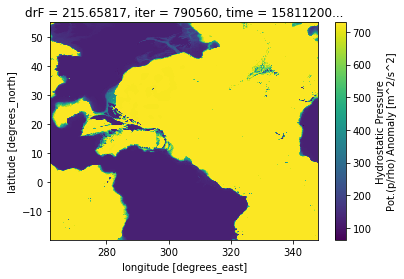

In [87]:
print(dsocn.PHIHYD.attrs, dsocn.ETAN.attrs)
dsocn.PHIHYD[0,30].plot()

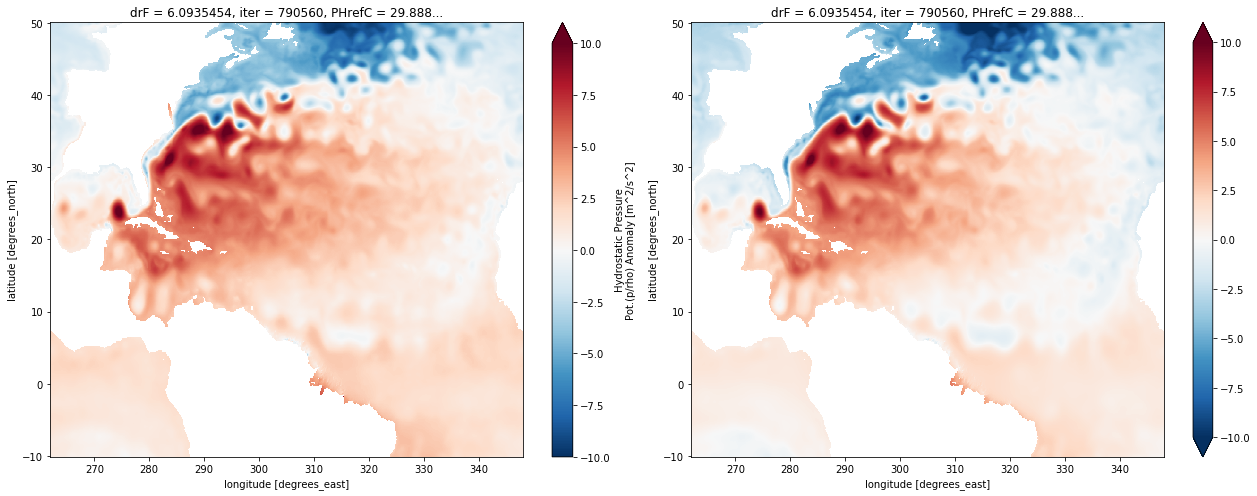

In [117]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
dsocn.PHIHYD.where(dsocn.maskC!=0.)[0,0].sel(YC=slice(ystart-12**-1,yend+12**-1)
                                             ).plot(ax=ax1, vmax=10)
(grav*rho_insitu*(dsocn.ETAN)/rhoConst)[0,0].sel(YC=slice(ystart-12**-1,yend+12**-1)
                                  ).plot(ax=ax2, vmax=10)

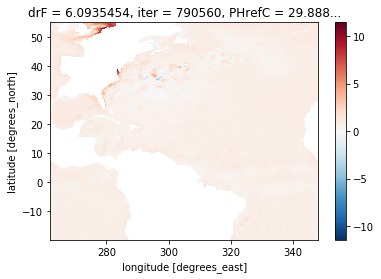

In [113]:
(dsocn.PHIHYD.where(dsocn.maskC!=0.)[0,0]-grav*(dsocn.ETAN)[0]).plot()

In [42]:
grid = xgrid(dsocn, periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

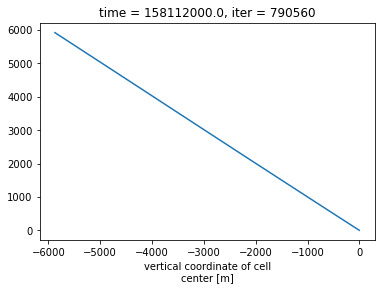

In [8]:
((dsocn.PHIHYD-grav*dsocn.Z)*rhoConst*1e-4).mean(['nmemb','YC','XC']).plot()

In [21]:
ZZ, _ = xr.broadcast(dsocn.Z, dsocn.ETAN[0])

In [8]:
rho_insitu = xr.apply_ufunc(jmd95.densjmd95, dsocn.SALT, dsocn.THETA,
                            (dsocn.PHIHYD-grav*dsocn.Z)*rhoConst*1e-4, # pressure in [dbar]!!!!
                            dask='parallelized', output_dtypes=[float]
                           ).where(dsocn.maskC!=0.)
rhox = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'X'), 
                      grid.interp(dsocn.THETA,'X'), 
                      grid.interp((dsocn.PHIHYD-grav*dsocn.Z)*rhoConst*1e-4,'X'), 
                      dask='parallelized', output_dtypes=[float]
                     ).where(dsocn.maskW!=0.)
rhoy = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'Y',boundary='fill'), 
                      grid.interp(dsocn.THETA,'Y',boundary='fill'), 
                      grid.interp((dsocn.PHIHYD-grav*dsocn.Z)*rhoConst*1e-4,'Y',boundary='fill'),
                      dask='parallelized', output_dtypes=[float]
                     ).where(dsocn.maskS!=0.)
# rhoz = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'Z',boundary='fill'), 
#                       grid.interp(dsocn.THETA,'Z',boundary='fill'), 
#                       grid.interp((dsocn.PHIHYD-grav*dsocn.Z)*rhoConst*1e-4,'Z',boundary='fill'),
#                       dask='parallelized', output_dtypes=[float]
#                      ).where(dsocn.maskInS!=0.)
rho_insitu

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
dask.array<where, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
    time     float64 1.581e+08
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    iter     int64 790560
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    maskInC  (YC, XC) bool False False False False ... False False False False
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9

In [7]:
rho2 = xr.apply_ufunc(jmd95.densjmd95, dsocn.SALT, dsocn.THETA, 20e2, 
                      dask='parallelized', output_dtypes=[float]
                     ).where(dsocn.maskC!=0.)
rho2x = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'X'), grid.interp(dsocn.THETA,'X'), 
                       20e2, 
                       dask='parallelized', output_dtypes=[float]
                      ).where(dsocn.maskC!=0.)
rho2y = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'Y',boundary='fill'), 
                       grid.interp(dsocn.THETA,'Y',boundary='fill'), 20e2, 
                       dask='parallelized', output_dtypes=[float]
                      ).where(dsocn.maskC!=0.)

rho2

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
dask.array<where, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    iter     int64 790560
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskInC  (YC, XC) bool False False False False ... False False False False
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    time     float64 1.581e+08
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9

Since we use potential density at 2000 dbar ($\rho_2$) as the buoyancy coordinate, we probably need to calculate the hydrostatic pressure using $\rho_2$ for consistency, i.e.:
$$\frac{\partial\phi}{\partial z} = -\frac{\rho_2g}{\rho_0}$$

$$\therefore \phi = -\frac{g}{\rho_0}\int^\eta_z \rho_2(z)\ dz \sim \frac{g}{\rho_0}\sum \rho_2 \Delta z.$$

<!-- Actually, **no because the hydrostatic pressure is calculated using insitu density** [(alphaRho)](https://github.com/MITgcm/MITgcm/blob/master/model/src/calc_phi_hyd.F). -->

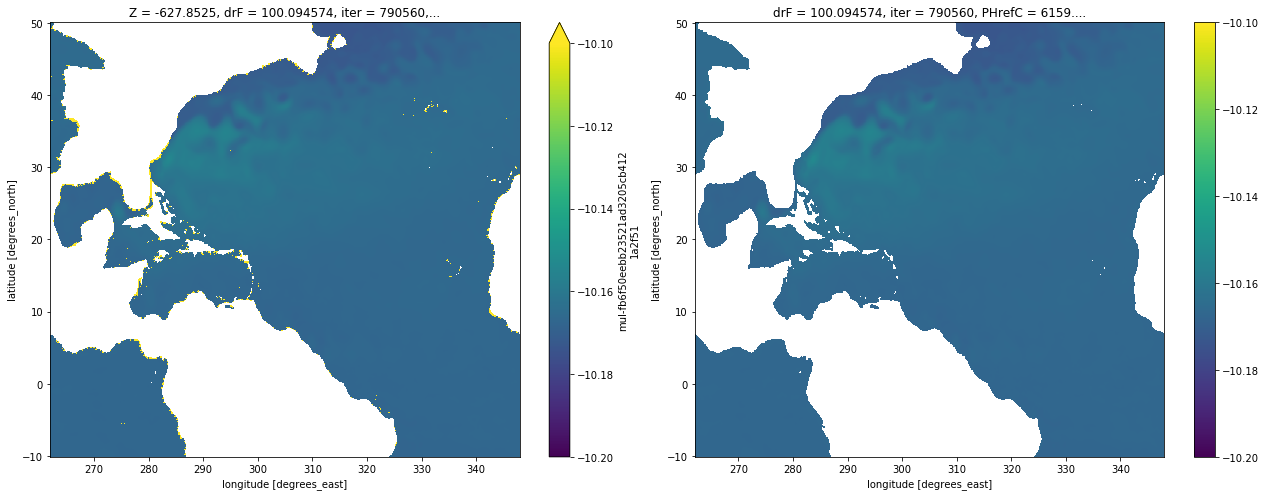

In [130]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
grid.interp(-grid.diff(phi*dsocn.hFacC,'Z',boundary='fill',to='outer') / dsocn.drC,
           'Z',boundary='fill').where(dsocn.maskC!=0.)[0,20].sel(YC=slice(ystart-12**-1,yend+12**-1)
                                                               ).plot(ax=ax1, vmax=-10.1, vmin=-10.2)
buoy[0,20].sel(YC=slice(ystart-12**-1,yend+12**-1)
                      ).plot(ax=ax2, vmax=-10.1, vmin=-10.2)

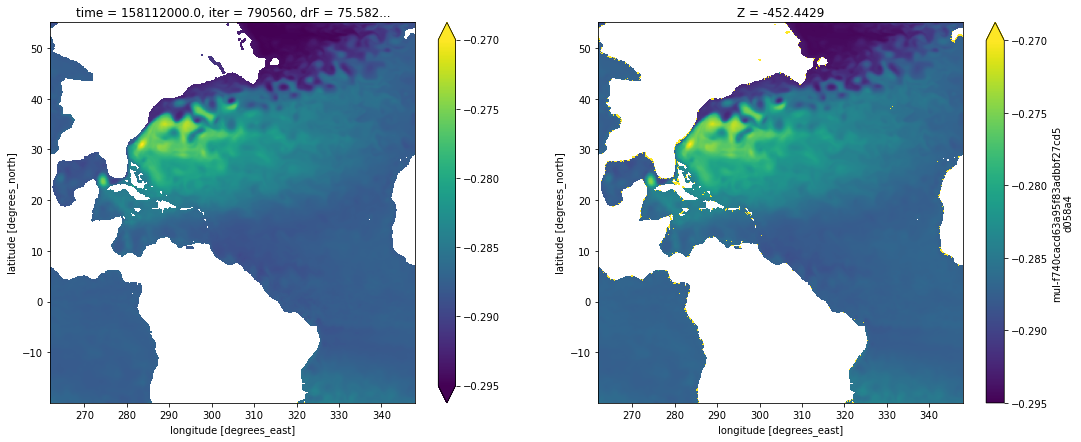

In [9]:
# buoy = grid.interp(-grid.diff(dsocn.PHIHYD.where(dsocn.maskC!=0.)*dsocn.hFacC,
#                               'Z',boundary='fill',to='outer'
#                              ) * dsocn.drC**-1,
#                    'Z', boundary='fill'
#                   ).chunk({'Z':-1})
buoy = -grav * (rho_insitu - rhoConst) * rhoConst**-1

fig, (ax1,ax2) = plt.subplots(figsize=(18,7), nrows=1, ncols=2)
buoy[0,18].plot(ax=ax1, vmin=-.295, vmax=-.27)
grid.interp(-grid.diff(dsocn.PHIHYD.where(dsocn.maskC!=0.)*dsocn.hFacC,
                       'Z',boundary='fill',to='outer'
                      ) * dsocn.drC**-1,
            'Z', boundary='fill'
           )[0,18].plot(ax=ax2, vmin=-.295, vmax=-.27)

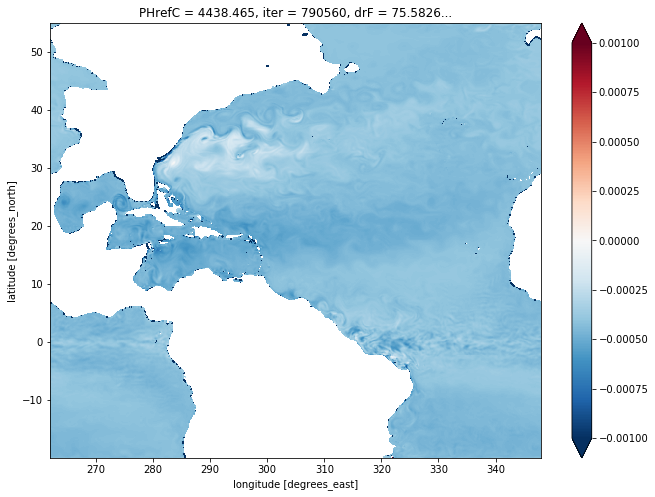

In [31]:
(buoy - grid.interp(-grid.diff(dsocn.PHIHYD.where(dsocn.maskC!=0.)*dsocn.hFacC,
                               'Z',boundary='fill',to='outer'
                              ) * dsocn.drC**-1,
                    'Z', boundary='fill'
                   ))[0,18].plot(figsize=(11,8), vmax=1e-3)

In [10]:
# sig_in_z = -grid.diff(buoy.where(dsocn.maskInC!=0.)*dsocn.hFacC,
#                       'Z',boundary='fill',to='outer')**-1 * dsocn.drC
m = dsocn.PHIHYD.where(dsocn.maskC!=0.) - buoy*dsocn.Z
# m = phi - buoy*dsocn.Z
m

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
dask.array<sub, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
    time     float64 1.581e+08
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    iter     int64 790560
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    maskInC  (YC, XC) bool False False False False ... False False False False
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.972

In [11]:
dbdx = (grid.diff(buoy * grid.interp(dsocn.dyG,'X'),
                  'X'
                 ) * dsocn.rAw**-1
       ).where(dsocn.maskW!=0.)
dbdy = (grid.diff(buoy * grid.interp(dsocn.dxG,'Y',boundary='fill'),
                  'Y',boundary='fill'
                 ) * dsocn.rAs**-1
       ).where(dsocn.maskS!=0.)

dmdx = (grid.diff(m * grid.interp(dsocn.dyG,'X'),
                  'X'
                 ) * dsocn.rAw**-1
       ).where(dsocn.maskW!=0.)
dmdy = (grid.diff(m * grid.interp(dsocn.dxG,'Y',boundary='fill'),
                  'Y',boundary='fill'
                 ) * dsocn.rAs**-1
       ).where(dsocn.maskS!=0.)
dbdy

<xarray.DataArray (nmemb: 2, Z: 46, YG: 900, XC: 1000)>
dask.array<where, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 899, 500), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YG       (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    dyC      (YG, XC) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
    dxG      (YG, XC) >f4 8993.141 8993.141 8993.141 ... 5493.54 5493.54 5493.54
    time     float64 1.581e+08
    maskInS  (YG, XC) bool False False False False False ... True True True True
    iter     int64 790560
    rAs      (YG, XC) >f4 83319550.0 83319550.0 ... 50896490.0 50896490.0
    maskS    (Z, YG, XC) bool True True True True ... False False False False
    hFacS    (Z, YG, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.915

(1020, 1060)

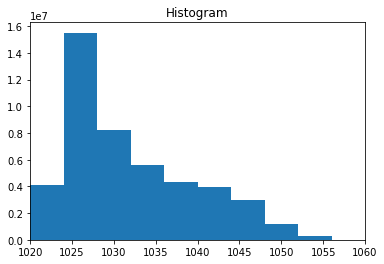

In [79]:
fig, ax = plt.subplots()
rho_insitu.plot.hist(ax=ax, range=(1020,1060))
ax.set_xlim([1020,1060])

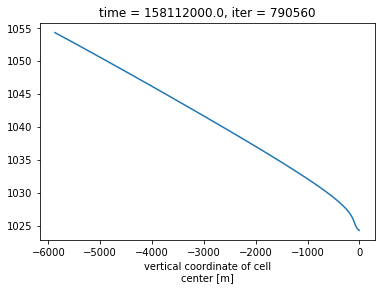

In [110]:
rho_insitu.mean(['nmemb','YC','XC']).plot()

In [48]:
fC = xr.apply_ufunc(gsw.f, dsocn.YC, dask='parallelized', output_dtypes=[float])
fG = xr.apply_ufunc(gsw.f, dsocn.YG, dask='parallelized', output_dtypes=[float])

px = grid.diff(dsocn.PHIHYD.where(dsocn.maskC!=0.)
               * grid.interp(dsocn.dyG,'X'),
               'X'
              ) * dsocn.rAw**-1
py = grid.diff(dsocn.PHIHYD.where(dsocn.maskC!=0.)
               * grid.interp(dsocn.dxG,'Y',boundary='fill'),
               'Y',boundary='fill'
              ) * dsocn.rAs**-1
vg = px*fC**-1
ug = -py*fG**-1
vg

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XG: 1000)>
dask.array<mul, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 499), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
    time     float64 1.581e+08
    rAw      (YC, XG) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    dyG      (YC, XG) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
    iter     int64 790560
    dxC      (YC, XG) >f4 8995.514 8995.514 8995.514 ... 5487.842 5487.842
    maskInW  (YC, XG) bool False False False False ... False False False False
Dimensions without coordinates: nmemb

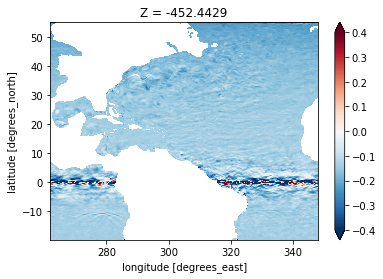

In [92]:
(grid.interp(dsocn.UVEL,'X')-grid.interp(ug,'Y',boundary='fill'))[0,18].plot(vmax=.4)

In [12]:
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(dsocn.drF.sel(Z=slice(None,None))),
                                                            np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
                                                            40)

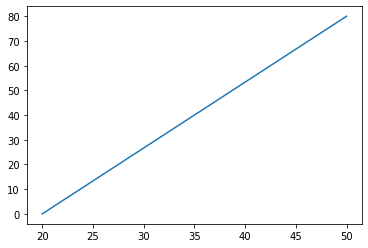

In [13]:
Dsig = 30
nlayers = 81

# tmp = np.tanh(np.linspace(-.75,1.75,nlayers))
# tmp += np.abs(tmp.min())
# tmp *= tmp.max()**-1 * Dsig
# # print(tmp)
# siglayers = 20. + tmp
siglayers = np.linspace(20,50,nlayers)
# siglayers = np.linspace(20,160,nlayers)
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))
plt.plot(siglayers, range(81))

In [52]:
# udz = xr.DataArray(np.ones((len(dsocn.nmemb),
#                             len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
#                             len(dsocn.XG),len(siglayers))),
#                    dims=['nmemb','YC','XG','sig'],
#                    coords={'nmemb':range(2),
#                            'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
#                            'XG':dsocn.XG.data,'sig':siglayers}
#                   ) * np.nan
# vdz = xr.DataArray(np.ones((len(dsocn.nmemb),
#                             len(dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
#                             len(dsocn.XC),len(siglayers))),
#                    dims=['nmemb','YG','XC','sig'],
#                    coords={'nmemb':range(2),
#                            'YG':dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
#                            'XC':dsocn.XC.data,'sig':siglayers}
#                   ) * np.nan
pdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XC),len(siglayers))),
                   dims=['nmemb','YC','XC','sig'],
                   coords={'nmemb':range(2),
                           'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XC':dsocn.XC.data,'sig':siglayers}
                  ) * np.nan
bdz = pdz.load().copy() * np.nan
pxdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XG),len(siglayers))),
                   dims=['nmemb','YC','XG','sig'],
                   coords={'nmemb':range(2),
                           'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XG':dsocn.XG.data,'sig':siglayers}
                   ) * np.nan
pydz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XC),len(siglayers))),
                   dims=['nmemb','YG','XC','sig'],
                   coords={'nmemb':range(2),
                           'YG':dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XC':dsocn.XC.data,'sig':siglayers}
                   ) * np.nan

for tt in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          px[tt].where(dsocn.maskW!=0.).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).chunk({'XG':xchunk}),
                          (rhox[tt]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          py[tt].where(dsocn.maskS!=0.).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),      
                          (rhoy[tt]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          dsocn.PHIHYD[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_insitu[tt]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp4 = xr.apply_ufunc(layers_numpy, 
                          buoy[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_insitu[tt]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

        
    pxdz[tt] = tmp1
    pydz[tt] = tmp2
    pdz[tt] = tmp3
    bdz[tt] = tmp4
    
    del tmp3

    
pxdz = pxdz.chunk({'nmemb':1,'sig':1})
pydz = pydz.chunk({'nmemb':1,'sig':1})
pdz = pdz.chunk({'nmemb':1,'sig':1})
bdz = bdz.chunk({'nmemb':1,'sig':1})
pdz

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 81)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 81), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0

In [22]:
mdz = pdz.load().copy() * np.nan

for tt in range(2):
    
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          m[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_insitu[tt]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    
    mdz[tt] = tmp3
    
    del tmp3

    
mdz = mdz.chunk({'nmemb':1,'sig':1})

In [15]:
zz, _ = xr.broadcast(dsocn.Z, rho_insitu[0].sel(YC=slice(ystart-12**-1,yend+2*12**-1)))
zzy, _ = xr.broadcast(dsocn.Z, rhoy[0].sel(YG=slice(ystart-12**-1,yend+2*12**-1)))
zzx, _ = xr.broadcast(dsocn.Z, rhox[0].sel(YC=slice(ystart-12**-1,yend+2*12**-1)))
# zzp1, _ = xr.broadcast(dsocn.Zp1, rho_insitu[0].sel(YC=slice(ystart-12**-1,yend+2*12**-1)))

In [16]:
dzetaF = pdz.load().copy() * np.nan
zdz = pdz.load().copy() * np.nan
zxdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XG),len(siglayers))),
                   dims=['nmemb','YC','XG','sig'],
                   coords={'nmemb':range(2),
                           'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XG':dsocn.XG.data,'sig':siglayers}
                   ) * np.nan
dzetaFx = zxdz.copy()
zydz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XC),len(siglayers))),
                   dims=['nmemb','YG','XC','sig'],
                   coords={'nmemb':range(2),
                           'YG':dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XC':dsocn.XC.data,'sig':siglayers}
                   ) * np.nan
dzetaFy = zydz.copy()
# zp1dz = pdz.load().copy() * np.nan


for j in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zz).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                               yend+2*12**-1)
                                                                     ),
                          (rho_insitu[j]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          zz.chunk({'XC':xchunk}),
                          (rho_insitu[j]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zzy).chunk({'XC':xchunk}),
                          (rhoy[j]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp4 = xr.apply_ufunc(layers_numpy, 
                          zzy.chunk({'XC':xchunk}),
                          (rhoy[j]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp5 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zzx).chunk({'XG':xchunk}),
                          (rhox[j]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp6 = xr.apply_ufunc(layers_numpy, 
                          zzx.chunk({'XG':xchunk}),
                          (rhox[j]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
            
    dzetaF[j] = tmp1.data
    zdz[j] = tmp2.data
    dzetaFy[j] = tmp3.data
    zydz[j] = tmp4.data
    dzetaFx[j] = tmp5.data
    zxdz[j] = tmp6.data
#     zldz[j] = tmp3.data
#     zp1dz[j] = tmp4.data
    
    del tmp1, tmp2, tmp3, tmp4, tmp5, tmp6
    
    
dzetaF = dzetaF.chunk({'nmemb':1,'sig':1})
zdz = zdz.chunk({'nmemb':1,'sig':1})
dzetaFy = dzetaFy.chunk({'nmemb':1,'sig':1})
zydz = zydz.chunk({'nmemb':1,'sig':1})
dzetaFx = dzetaFx.chunk({'nmemb':1,'sig':1})
zxdz = zxdz.chunk({'nmemb':1,'sig':1})
# zldz = zldz.chunk({'nmemb':1,'sigl':1})
# zp1dz = zp1dz.chunk({'nmemb':1,'sig':1})
dzetaF

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 81)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 81), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0

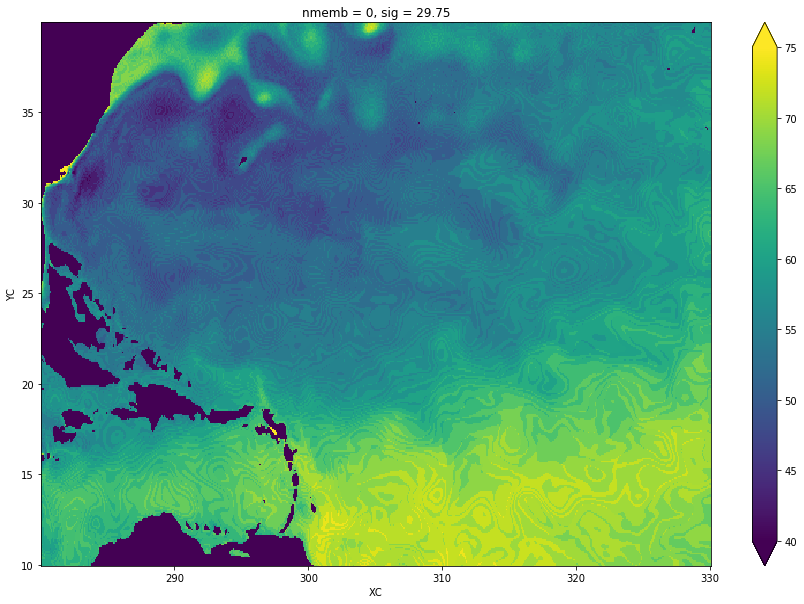

In [18]:
(dzetaF[0,:,:,26].sel(YC=slice(10,40),XC=slice(280,330))).plot(figsize=(15,10), vmax=75, vmin=40)

In [17]:
dssig = zdz.to_dataset(name='zdz')
dssig.coords['YG'] = ('YG',dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data)
dssig.coords['XG'] = ('XG',dsocn.XG.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
dssig.coords['sigp1'] = ('sigp1',sigp1layers)
# dt = np.diff(ds.time)[0]
# dssig.coords['timep1'] = rhoConstmep1',np.append(np.append(ds.time[0].data-.5*dt,
#                                                        .5*(ds.time[1:].data+ds.time[:-1].data)),
#                                              ds.time[-1].data+.5*dt))
dssig

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 723, YG: 723, nmemb: 2, sig: 81, sigp1: 82)
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sigp1    (sigp1) float64 19.81 20.19 20.56 20.94 ... 49.06 49.44 49.81 50.19
Data variables:
    zdz      (nmemb, YC, XC, sig) float64 dask.array<chunksize=(1, 723, 1000, 1), meta=np.ndarray>

In [41]:
grids = xgrid(dssig, periodic=['X'], 
              coords={'Z':{'center':'sig','outer':'sigp1'},
                      'Y':{'center':'YC','left':'YG'},
                      'X':{'center':'XC','left':'XG'}}
             )
grids

<xgcm.Grid>
Z Axis (not periodic):
  * center   sig --> outer
  * outer    sigp1 --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

$$\zeta = \sum_{\tilde{b}}\Delta\zeta\ ,\ \ \sigma = \frac{\partial\zeta}{\partial\tilde{b}} = \frac{\delta_k(\zeta A_b)}{A_b\delta_k \tilde{b}} \simeq \frac{\delta_k \zeta}{\delta_k \tilde{b}}$$
where the buoyancy coordinate $\tilde{b}=b=\frac{\partial\phi}{\partial z}=-g\frac{\rho-\rho_0}{\rho_0}$ is defined using the in-situ density, which we will refer to as *in-situ buoyancy* hereon. Hence, the Montgomery potential can be simply defined as:
$$m = \phi - \tilde{b}\zeta$$
and allows for all the desirable characteristics of Young (2012) such as the hydrostatic balance to hold:
$$\frac{\partial m}{\partial\tilde{b}} = \frac{\partial}{\partial\tilde{b}}(\phi - \tilde{b}\zeta)$$
$$\ \ \ \ \ \ \ \ = \frac{\partial\phi}{\partial\tilde{b}} - \zeta - b\frac{\partial\zeta}{\partial\tilde{b}}$$
$$\ \ \ \ \ \ \ \ \ \ \ \ \ = \frac{\partial\phi}{\partial\zeta}\frac{\partial\zeta}{\partial\tilde{b}} - \zeta - b\frac{\partial\zeta}{\partial\tilde{b}}$$
$$= -\zeta.$$
<!-- We can flip this relation around to derive $m$:
$$m = -\int \zeta\ d\tilde{b}.$$ -->
Using in-situ buoyancy introduces, however, the effect of compressibility, i.e.
$$\frac{D\rho}{Dt} - \frac{1}{c_s^2}\frac{DP}{Dt} = -\frac{\rho_0}{g}\varpi$$
and buoyancy is no longer conserved ($\frac{Db}{Dt}\neq 0$) even under adiabatic conditions. With $dP = -\rho g\ dz$, we get
$$\frac{D\rho}{Dt} + \frac{\rho g}{c_s^2}\frac{Dz}{Dt} \simeq -\frac{\rho_0}{g}\varpi$$
$$\therefore\ \rho_t + u\rho_x + v\rho_y + w\rho_z + \frac{\rho gw}{c_s^2} \simeq -\frac{\rho_0}{g}\varpi$$

In [93]:
cos_1 = np.sqrt(1 + (dzetaF/grid.interp(dsocn.dxG,'Y',boundary='fill'))**2 
                + (dzetaF/grid.interp(dsocn.dyG,'X'))**2
               )
cos_1y = np.sqrt(1 + (dzetaFy/dsocn.dxG)**2 
                 + (dzetaFy
                    / grid.interp(grid.interp(dsocn.dyG,'X'),'Y',boundary='fill')
                   )**2
                )
cos_1x = np.sqrt(1 + (dzetaFx
                      / grid.interp(grid.interp(dsocn.dxG,'Y',boundary='fill'),'X')
                     )**2 
                 + (dzetaFx/dsocn.dyG)**2
                )
cos_1z = np.sqrt(1 + (grids.interp(dzetaF,'Z',boundary='fill')
                      / grid.interp(dsocn.dxG,'Y',boundary='fill')
                     )**2 
                 + (grids.interp(dzetaF,'Z',boundary='fill')
                    / grid.interp(dsocn.dyG,'X')
                   )**2
                )

# print(angle,angley,anglex,anglez)

<xarray.DataArray (nmemb: 2, YG: 723, XC: 1000, sig: 81)>
dask.array<mul, shape=(2, 723, 1000, 81), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float64 -10.04 -9.958 -9.875 -9.792 ... 49.96 50.04 50.13
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0
    dyC      (YG, XC) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
    rAs      (YG, XC) >f4 87285460.0 87285460.0 ... 56830530.0 56830530.0
    dxG      (YG, XC) >f4 9421.203 9421.203 9421.203 ... 6134.034 6134.034
    maskInS  (YG, XC) bool True True True True True ... True True True True True
    iter     int64 790560
    time     float64 1.581e+08

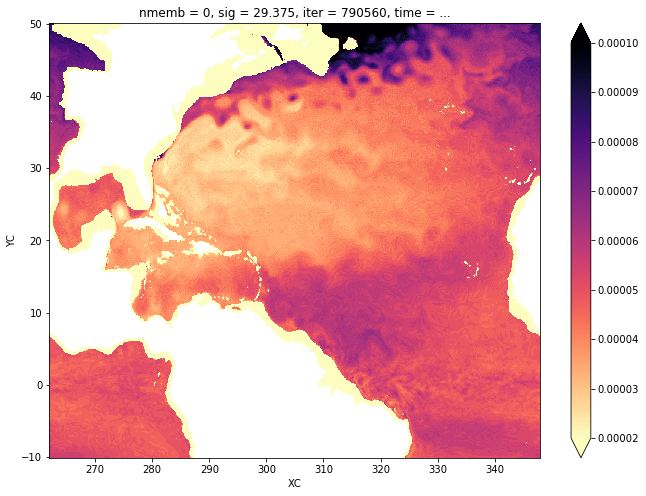

In [94]:
rAb = cos_1 * dsocn.rA.where(dsocn.maskInC!=0.)
rAbz = cos_1z * dsocn.rA.where(dsocn.maskInC!=0.)
rAbw = cos_1x * dsocn.rAw.where(dsocn.maskInW!=0.)
rAbs = cos_1y * dsocn.rAs.where(dsocn.maskInS!=0.)

(rAb[0,:,:,25]/dsocn.rA.where(dsocn.maskInC!=0.) - 1.).plot(figsize=(11,8), vmin=2e-5, vmax=1e-4, cmap='magma_r')
rAbs

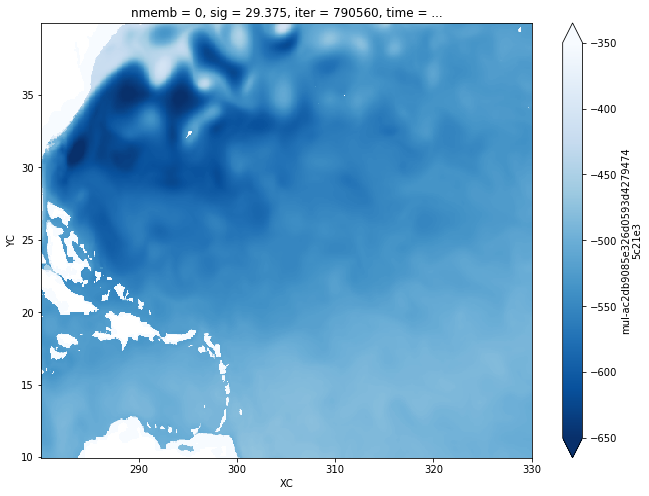

In [41]:
zeta = -grids.interp(grids.cumsum(dzetaF,'Z',boundary='fill'),
                     'Z',boundary='fill'
                    ).where(dsocn.maskInC!=0.)

zeta.where(zeta!=0.).sel(YC=slice(10,40),
                         XC=slice(280,330))[0,:,:,25].plot(cmap='Blues_r', figsize=(11,8), 
                                                           vmax=-350, vmin=-650)

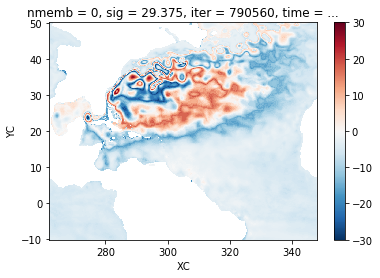

In [71]:
(zdz*dzetaF**-1 - zeta)[0,:,:,25].plot()

In [19]:
buoyb = -grav * dssig.sig * rhoConst**-1
buoybp1 = -grav * dssig.sigp1 * rhoConst**-1

# sigma2 = (dzetaF.where(dsocn.maskInC!=0.) 
#           * (grav*rhoConst**-1*grids.diff(dssig.sigp1,'Z',boundary='fill'))**-1         
#          )
# sigma2 = (dzetaF.where(dsocn.maskInC!=0.) 
#           * (grids.interp(-grids.diff(bdz*dzetaF**-1,'Z',boundary='fill'),
#                           'Z',boundary='fill'))**-1         
#          )
sigma = dzetaF * -grids.diff(buoybp1,'Z',boundary='fill')**-1

phib = grids.interp(grids.cumsum(-bdz,'Z',boundary='fill'),'Z',boundary='fill')
# phib = grids.interp(grids.cumsum(-dzetaF*buoyb,'Z',boundary='fill'),'Z',boundary='fill')

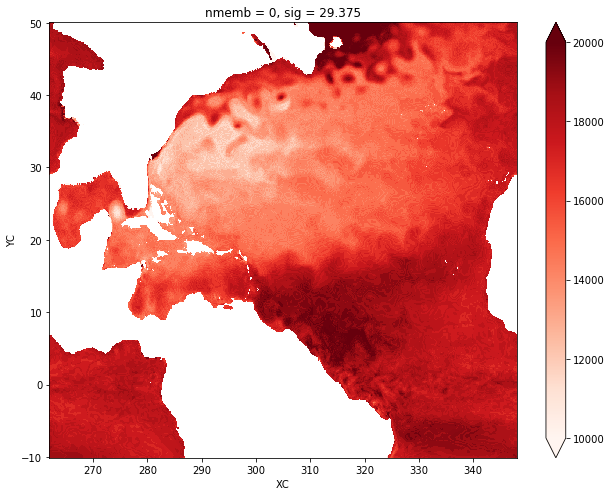

In [43]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9,7))  
fig.set_tight_layout(True)
sigma.where(sigma!=0.)[0,:,:,25].sel(YC=slice(ystart-12**-1,yend+12**-1)
                                    ).plot(ax=ax1, cmap='Reds',
                                           vmin=10e3, vmax=2e4)
# sigma2.where(sigma2!=0.)[0,:,:,25].sel(YC=slice(ystart-12**-1,yend+12**-1)
#                                       ).plot(ax=ax2, cmap='Reds',
#                                              vmin=5e3, vmax=2e4
#                                             )

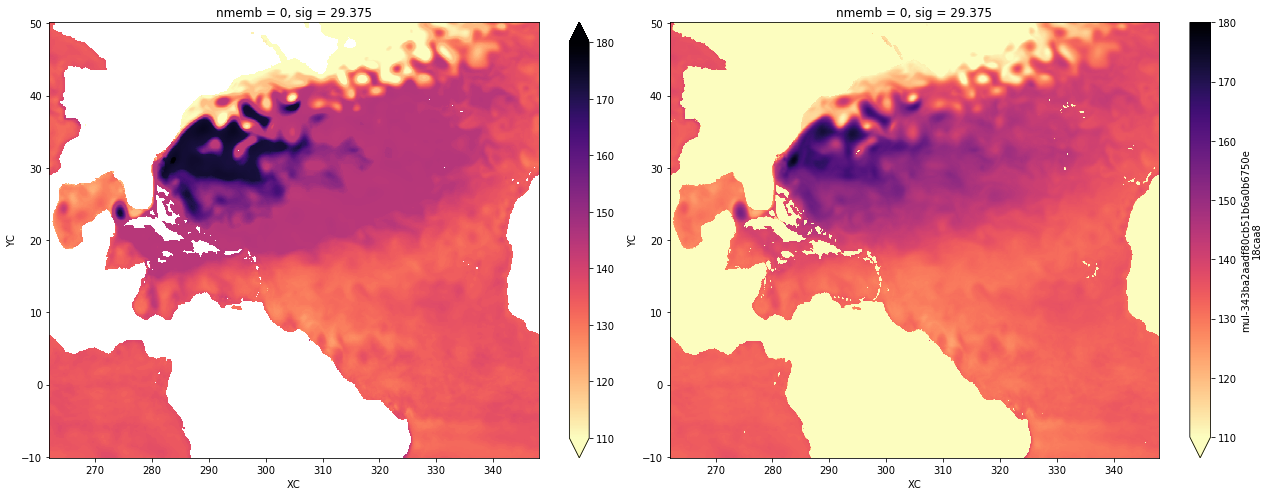

In [73]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
# (dsocn.PHIHYD).where(dsocn.maskC!=0.)[0,19].sel(YC=slice(ystart-12**-1,yend+12**-1)
#                                                ).plot(ax=ax1, cmap='hot_r')
(pdz*dzetaF**-1)[0,:,:,25].plot(ax=ax1, cmap='magma_r', vmax=180, vmin=110)
phib[0,:,:,25].plot(ax=ax2, cmap='magma_r', vmax=180, vmin=110)

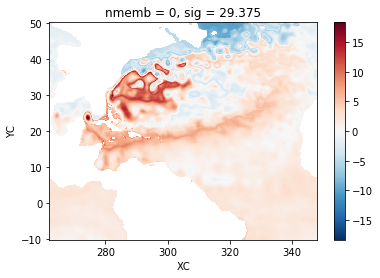

In [74]:
(pdz*dzetaF**-1 - phib)[0,:,:,25].plot()

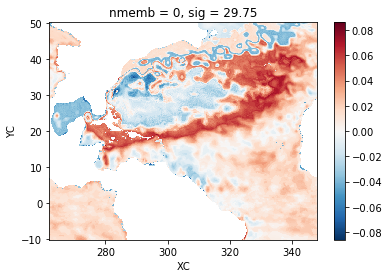

In [140]:
(-grids.interp(grids.diff(pdz*dzetaF**-1,'Z',boundary='fill')
               * (grids.interp(dzetaF,'Z',boundary='fill'))**-1,
               'Z',boundary='fill'
              )
 - buoyb)[0,:,:,26].plot()
# ((grids.interp(-grids.diff(pdz*dzetaF**-1,'Z',boundary='fill'),
#                'Z',boundary='fill') 
#   - bdz
#  )*dzetaF**-1)[0,:,:,25].plot()

In [33]:
# sigma = (dzetaF.where(dsocn.maskInC!=0.) 
#          * -grids.diff(bdz*dzetaF**-1,'Z',boundary='fill')**-1
#         )
# mb = (pdz - zeta*bdz)*dzetaF**-1
# mb2 = pdz*dzetaF**-1 - zeta*buoyb
# mb2 = phib.where(phib!=0.) - zeta*buoyb
mb = (pdz - zdz*buoyb)*dzetaF**-1
mb2 = -grids.interp(grids.cumsum(zdz*dzetaF**-1 * -grids.diff(buoybp1,'Z',boundary='fill'),
                                 'Z',boundary='fill'),
                    'Z',boundary='fill').where(dsocn.maskInC!=0.)
# phib = -grids.cumsum(dzetaF*buoyb,'Z',boundary='fill')
# mb = grids.interp(phib,'Z',boundary='fill') - zeta*buoyb
mb

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 81)>
dask.array<mul, shape=(2, 723, 1000, 81), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0

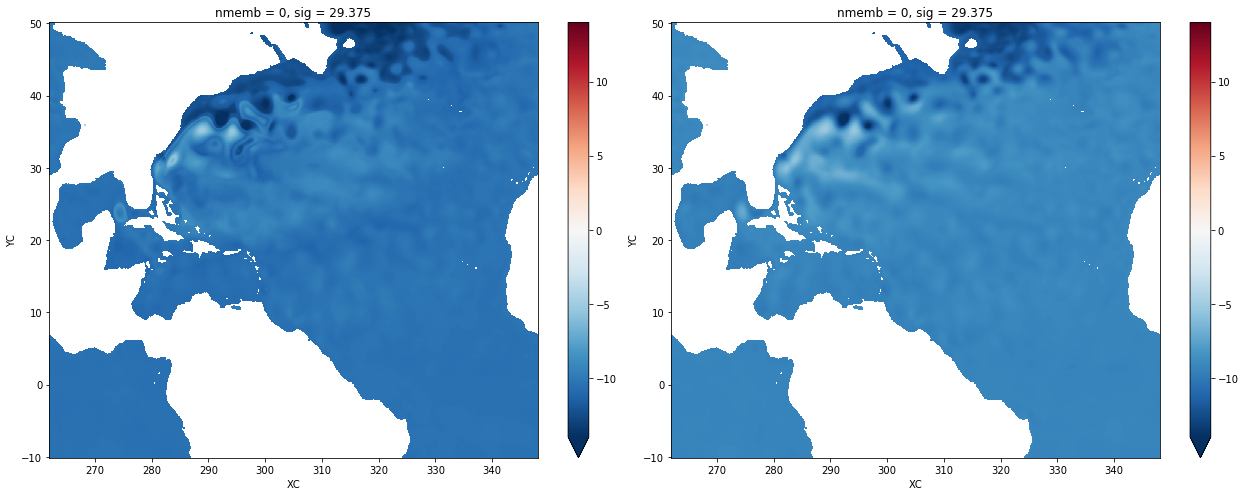

In [24]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
# (dsocn.PHIHYD).where(dsocn.maskC!=0.)[0,19].sel(YC=slice(ystart-12**-1,yend+12**-1)
#                                                ).plot(ax=ax1, cmap='hot_r')
(mdz*dzetaF**-1)[0,:,:,25].plot(ax=ax1, cmap='RdBu_r', vmax=14)
mb[0,:,:,25].plot(ax=ax2, cmap='RdBu_r', vmax=14)

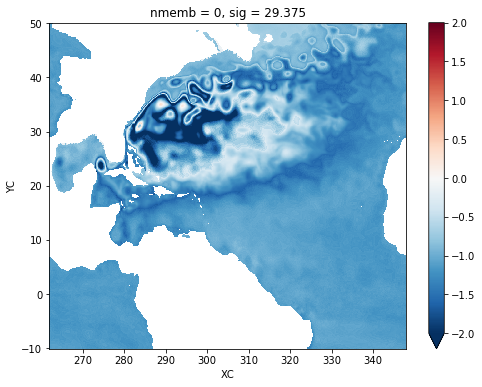

In [28]:
(mdz*dzetaF**-1 - mb)[0,:,:,25].plot(cmap='RdBu_r', vmax=2, figsize=(8,6))

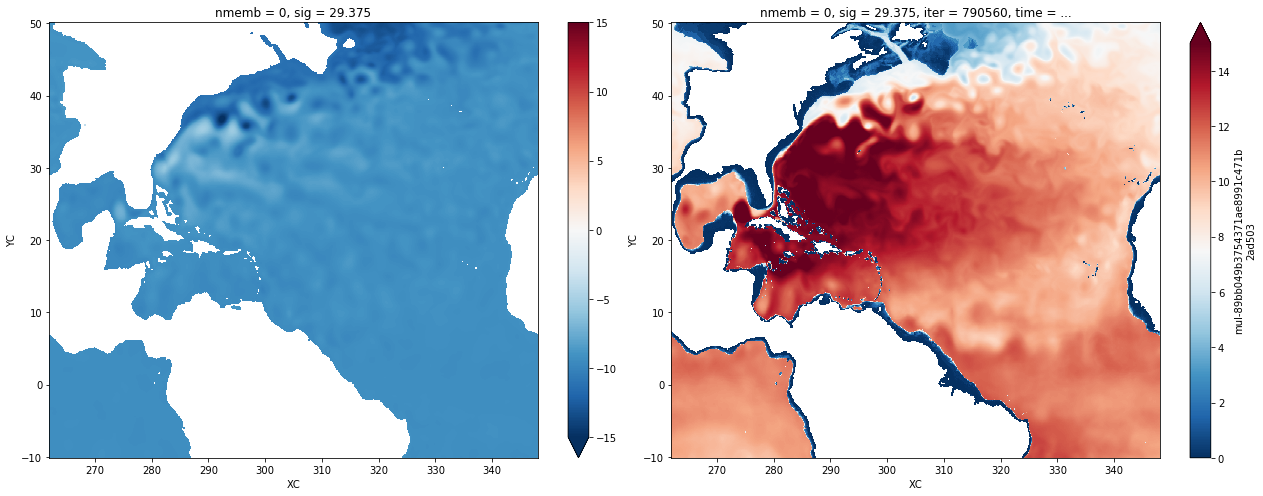

In [36]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
mb[0,:,:,25].plot(ax=ax1, cmap='RdBu_r', vmax=15)
mb2[0,:,:,25].plot(ax=ax2, cmap='RdBu_r', vmax=15)

In [29]:
# mb_b = grids.interp(grids.diff(mb*rAb,'Z',boundary='fill') 
#                     * (rAbz*grids.diff(buoyb,'Z',boundary='fill'))**-1,
#                     'Z', boundary='fill'
#                    )
mb_b = grids.interp(grids.diff(mb,'Z',boundary='fill') 
                    * grids.diff(buoyb,'Z',boundary='fill')**-1,
                    'Z',boundary='fill'
                   )
# mb_b2 = grids.interp(-grids.diff(mb,'Z',boundary='fill') 
#                      * (grids.interp(dzetaF,'Z',boundary='fill'))**-1,
#                      'Z', boundary='fill'
#                     ) * sigma
# mb_b2 = grids.interp(-grids.diff(mb2,'Z',boundary='fill') 
#                      * grids.diff(buoyb,'Z',boundary='fill')**-1,
#                      'Z',boundary='fill'
#                     )
mb_b2 = grids.interp(grids.diff(mdz*dzetaF**-1,'Z',boundary='fill') 
                     * grids.diff(buoyb,'Z',boundary='fill')**-1,
                     'Z',boundary='fill'
                    )

mb_b2

<xarray.DataArray 'mul-51896f2913c0f1160de2457b740c8f95' (nmemb: 2, YC: 723, XC: 1000, sig: 81)>
dask.array<mul, shape=(2, 723, 1000, 81), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0

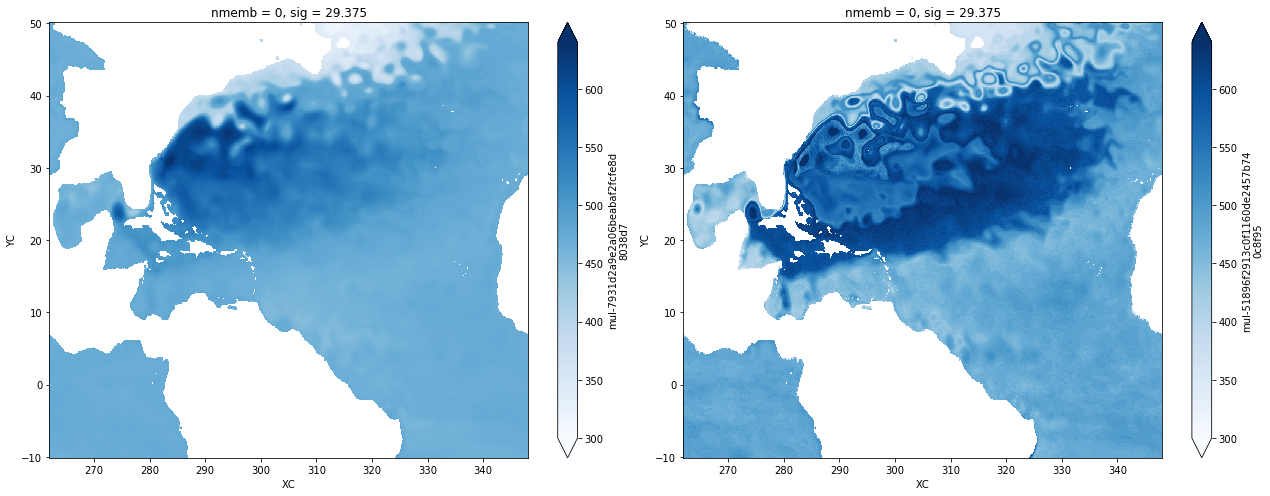

In [30]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
mb_b[0,:,:,25].plot(ax=ax1, cmap='Blues', vmin=300, vmax=640)
mb_b2[0,:,:,25].plot(ax=ax2, cmap='Blues', vmin=300, vmax=640)

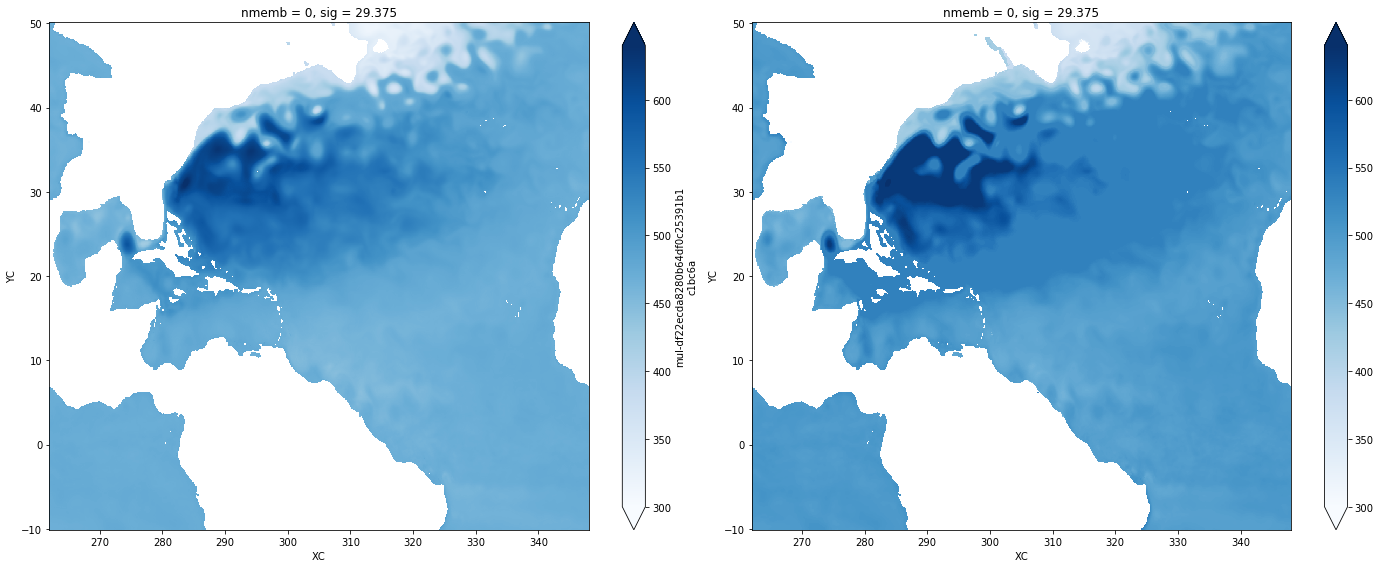

In [39]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
fig.set_tight_layout(True)
(mb_b)[0,:,:,25].plot(ax=ax1, vmin=3e2, vmax=6.4e2, cmap='Blues')
(-zdz*dzetaF**-1)[0,:,:,25].plot(ax=ax2, vmin=3e2, vmax=6.4e2, cmap='Blues')

In [34]:
bxdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XG),len(siglayers))),
                   dims=['nmemb','YC','XG','sig'],
                   coords={'nmemb':range(2),
                           'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XG':dsocn.XG.data,'sig':siglayers}
                   ) * np.nan
bydz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XC),len(siglayers))),
                   dims=['nmemb','YG','XC','sig'],
                   coords={'nmemb':range(2),
                           'YG':dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XC':dsocn.XC.data,'sig':siglayers}
                   ) * np.nan
mxdz = bxdz.copy()
mydz = bydz.copy()

for tt in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          dmdx[tt].sel(YC=slice(ystart-12**-1,yend+2*12**-1)).chunk({'XG':xchunk}),
                          (rhox[tt]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          dmdy[tt].sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          (rhoy[tt]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          dbdx[tt].sel(YC=slice(ystart-12**-1,yend+2*12**-1)).chunk({'XG':xchunk}),
                          (rhox[tt]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp4 = xr.apply_ufunc(layers_numpy, 
                          dbdy[tt].sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          (rhoy[tt]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    mxdz[tt] = tmp1
    mydz[tt] = tmp2
    bxdz[tt] = tmp3
    bydz[tt] = tmp4
    
    del tmp1, tmp2, tmp3, tmp4

    
mxdz = mxdz.chunk({'nmemb':1,'sig':1})
mydz = mydz.chunk({'nmemb':1,'sig':1})
bxdz = bxdz.chunk({'nmemb':1,'sig':1})
bydz = bydz.chunk({'nmemb':1,'sig':1})

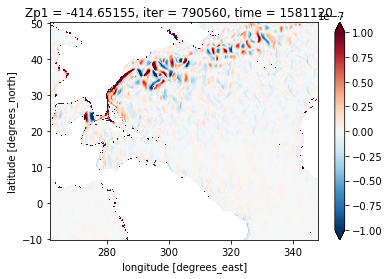

In [61]:
(-grid.diff(vg,'Z',boundary='fill',to='outer')
 * fC*dsocn.drC**-1).sel(YC=slice(ystart-12**-1,yend+2*12**-1))[0,18].plot(vmax=1e-7)

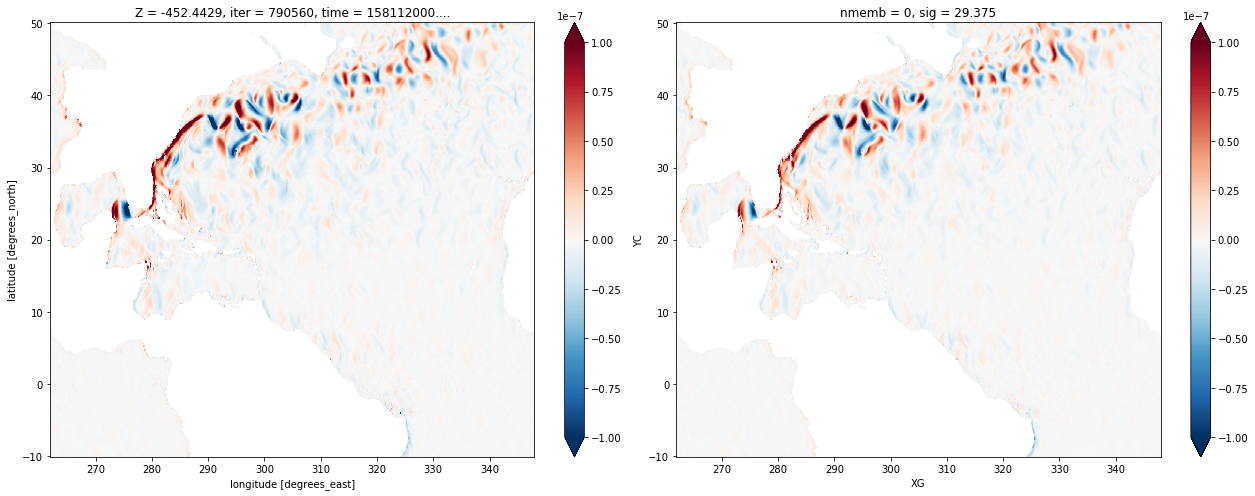

In [60]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
# (dsocn.PHIHYD).where(dsocn.maskC!=0.)[0,19].sel(YC=slice(ystart-12**-1,yend+12**-1)
#                                                ).plot(ax=ax1, cmap='hot_r')
(dbdx).sel(YC=slice(ystart-12**-1,yend+2*12**-1))[0,18].plot(ax=ax1, cmap='RdBu_r', vmax=1e-7)
(bxdz*dzetaFx**-1)[0,:,:,25].plot(ax=ax2, cmap='RdBu_r', vmax=1e-7)

In [103]:
# vgb = (grids.diff(mb * grid.interp(dsocn.dyG,'X'),
#                   'X'
#                  ) * dsocn.rAw**-1
#        + bxdz*zxdz*dzetaFx**-2
#       ) * fC**-1

# ugb = -(grids.diff(mb * grid.interp(dsocn.dxG,'Y',boundary='fill'),
#                    'Y',boundary='fill'
#                   ) * dsocn.rAs**-1
#         + bydz*zydz*dzetaFy**-2
#        ) * fG**-1
######################
# vgb = -(grids.diff(-mb * grid.interp(dsocn.dyG,'X'),
#                   'X'
#                  ) * dsocn.rAw**-1
#        + bxdz*zxdz*dzetaFx**-2
#       ) * fC**-1

# ugb = (grids.diff(-mb * grid.interp(dsocn.dxG,'Y',boundary='fill'),
#                    'Y',boundary='fill'
#                   ) * dsocn.rAs**-1
#         + bydz*zydz*dzetaFy**-2
#        ) * fG**-1
######################
# vgb = (grids.diff(mb * np.sqrt(dzetaF**2 + grid.interp(dsocn.dyG,'X')**2),
#                   'X'
#                  ) 
#        * rAbw**-1 * fC**-1)
# ugb = -(grids.diff(mb * np.sqrt(dzetaF**2 + grid.interp(dsocn.dxG,'Y',boundary='fill')**2),
#                    'Y',boundary='fill'
#                   ) 
#         * rAbs**-1 * fG**-1)
######################
mbx = (mxdz + bxdz*zxdz*dzetaFx**-1) * dzetaFx**-1
mby = (mydz + bydz*zydz*dzetaFy**-1) * dzetaFy**-1
vgb = mbx * fC**-1
ugb = -mby * fG**-1

ugb

<xarray.DataArray (nmemb: 2, YG: 723, XC: 1000, sig: 81)>
dask.array<mul, shape=(2, 723, 1000, 81), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float64 -10.04 -9.958 -9.875 -9.792 ... 49.96 50.04 50.13
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0
    iter     int64 790560
    time     float64 1.581e+08

In [50]:
ugdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                             len(dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                             len(dsocn.XC),len(siglayers))),
                    dims=['nmemb','YG','XC','sig'],
                    coords={'nmemb':range(2),
                            'YG':dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                            'XC':dsocn.XC.data,'sig':siglayers}
                   ) * np.nan
vgdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                             len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                             len(dsocn.XG),len(siglayers))),
                    dims=['nmemb','YC','XG','sig'],
                    coords={'nmemb':range(2),
                            'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                            'XG':dsocn.XG.data,'sig':siglayers}
                   ) * np.nan

for tt in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          vg[tt].where(dsocn.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                     yend+2*12**-1)
                                                           ).chunk({'XG':xchunk}),
                          (rhox[tt]-rhoConst).where(dsocn.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                                  yend+2*12**-1)
                                                                    ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          ug[tt].where(dsocn.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                     yend+2*12**-1)
                                                           ).chunk({'XC':xchunk}),
                          (rhoy[tt]-rhoConst).where(dsocn.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                                  yend+2*12**-1)
                                                                    ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    

        
    ugdz[tt] = tmp2
    vgdz[tt] = tmp1
    
    del tmp1, tmp2

    
ugdz = ugdz.chunk({'nmemb':1,'sig':1})
vgdz = vgdz.chunk({'nmemb':1,'sig':1})

ug_true = ugdz * grids.interp(dzetaF,'Y',boundary='fill')**-1
vg_true = vgdz * grids.interp(dzetaF,'X')**-1
vg_true

<xarray.DataArray (nmemb: 2, YC: 723, XG: 1000, sig: 81)>
dask.array<mul, shape=(2, 723, 1000, 81), dtype=float64, chunksize=(1, 723, 999, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0

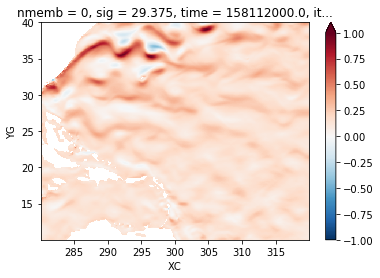

In [55]:
(-pydz*dzetaFy**-1 * fG**-1).sel(YG=slice(10,40),XC=slice(280,320))[0,:,:,25].plot(vmax=1)

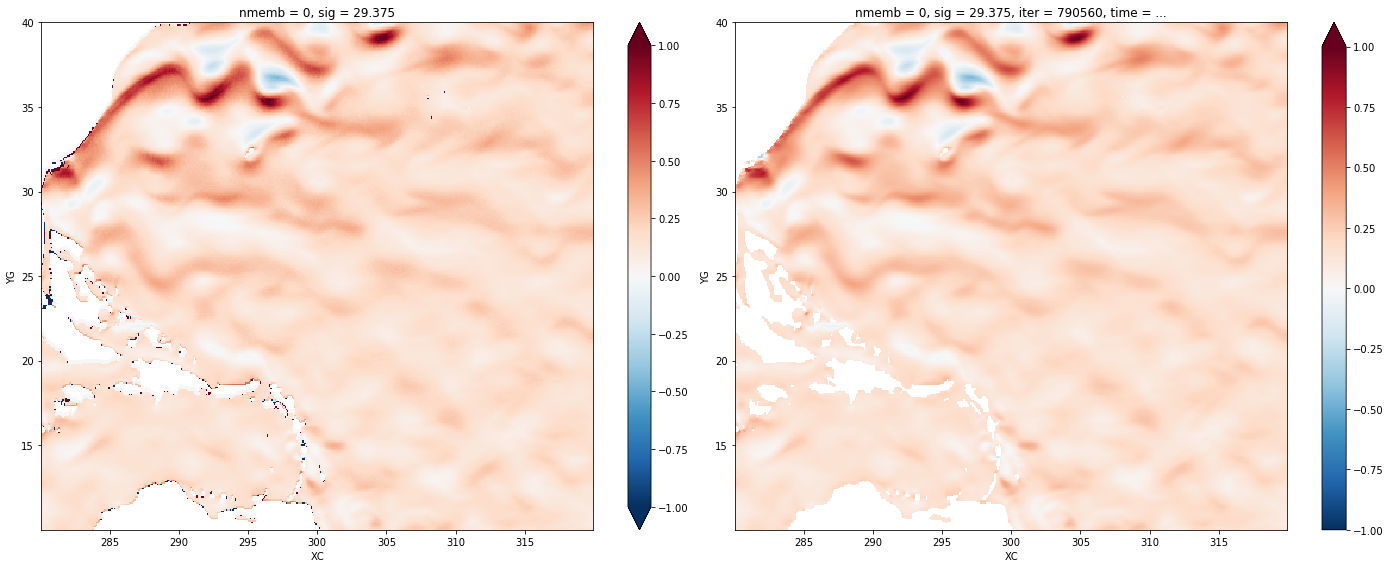

In [102]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
fig.set_tight_layout(True)
ug_true.sel(YG=slice(10,40),XC=slice(280,320))[0,:,:,25].plot(ax=ax1, vmax=1)
ugb.sel(YG=slice(10,40),XC=slice(280,320))[0,:,:,25].plot(ax=ax2, vmax=1)

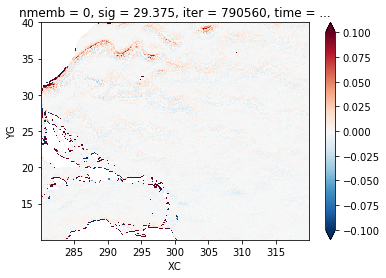

In [108]:
(ug_true-ugb).sel(YG=slice(10,40),XC=slice(280,320))[0,:,:,25].plot(vmax=.1)

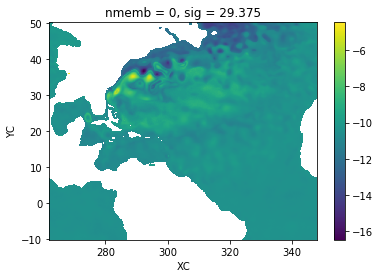

In [47]:
(mdz*dzetaF**-1)[0,:,:,25].plot()

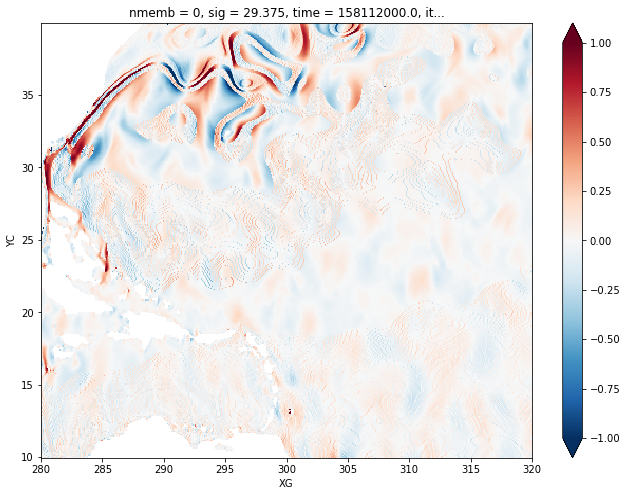

In [46]:
(grids.diff(mdz*dzetaF**-1 * grid.interp(dsocn.dyG,'X'),'X') 
 * dsocn.rAw**-1 * fC**-1).sel(YC=slice(10,40),XG=slice(280,320))[0,:,:,25].plot(figsize=(11,8), vmax=1)

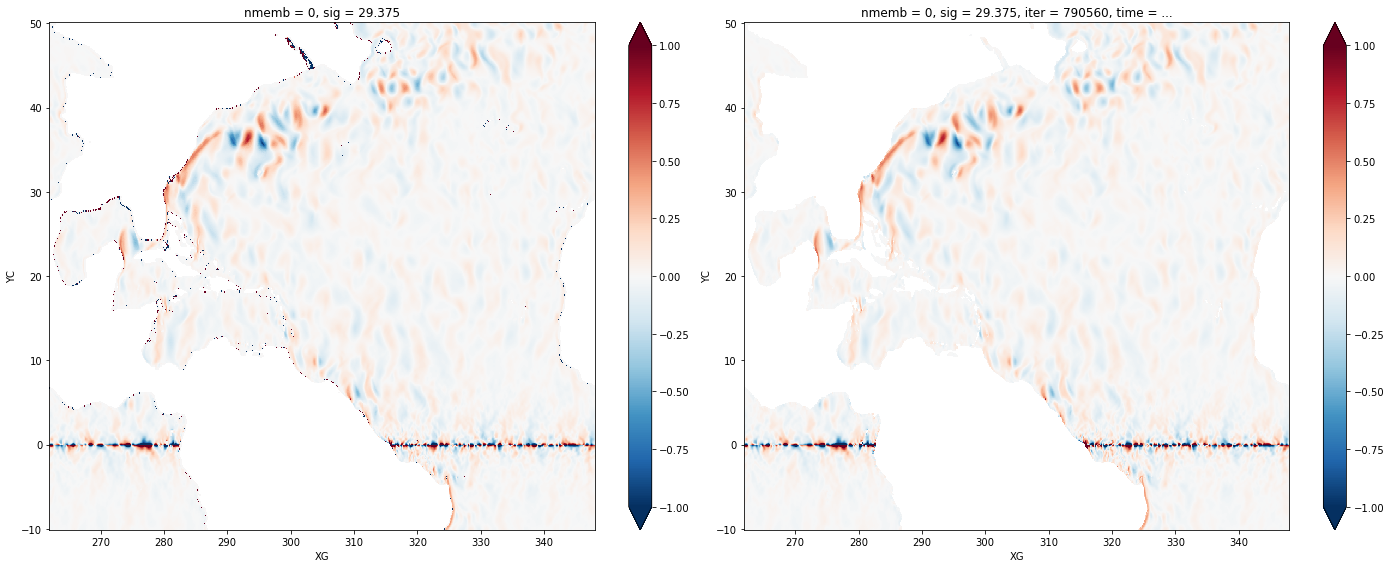

In [104]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
fig.set_tight_layout(True)
vg_true[0,:,:,25].plot(ax=ax1, vmax=1)
(vgb[0,:,:,25]).plot(ax=ax2, vmax=1)

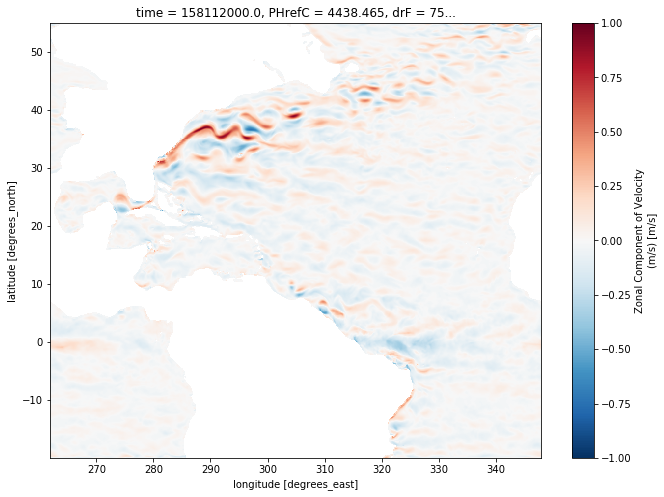

In [194]:
dsocn.UVEL.where(dsocn.maskW!=0.)[0,18].plot(figsize=(11,8), vmax=1)

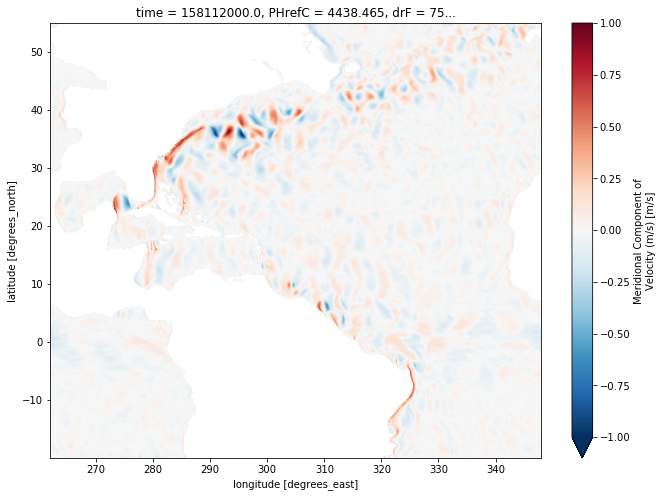

In [196]:
dsocn.VVEL.where(dsocn.maskS!=0.)[0,18].plot(figsize=(11,8), vmax=1)